In [62]:
from torchvision import datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np

In [63]:
data_folder = "C:/Users/user/data/FMNIST/"
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

In [71]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ix):

        return self.x[ix].to(device), self.y[ix].to(device)

In [72]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trainloader = DataLoader(train, batch_size=32, shuffle=True)
    return trainloader

from torch.optim import SGD
def get_model():
    model = nn.Sequential(
            nn.Linear(28*28, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
    ).to(device)
    
    opt = SGD(model.parameters(), lr= 0.01)
    loss = nn.CrossEntropyLoss()
    
    return model, opt, loss

def train_batch(x, y, model, opt, loss):
    model.train()
    opt.zero_grad()
    pred = model.forward(x)
    criterion = loss(pred, y)
    criterion.backward()
    opt.step()
    
    return criterion.item()
    
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    pred = model(x)
    
    max_val, argmax = pred.max(-1)
    is_correct = argmax == y  #0 or 1
    return is_correct.cpu().numpy().tolist()

In [73]:
trainloader = get_data()
model, opt, loss = get_model()

losses, accuracies = [], []

for epoch in range(5):
    print("Epoch: ", epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trainloader)):
        x, y = batch
        batch_loss = train_batch(x, y, model, opt, loss)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trainloader)):
        x, y =batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4


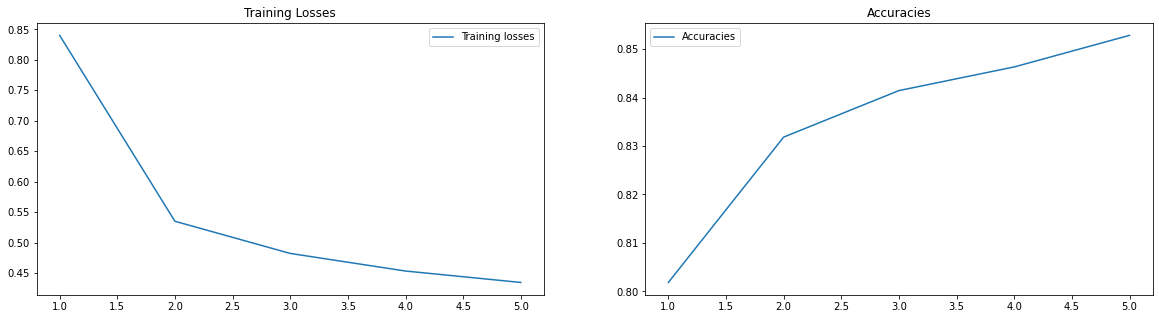

In [75]:
epochs = np.arange(5)+1

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Training Losses")
plt.plot(epochs, losses, label='Training losses')
plt.legend()

plt.subplot(122)
plt.title("Accuracies")
plt.plot(epochs, accuracies, label="Accuracies")
plt.legend()